In [2]:
import math
import networkx as nx
import osmnx as ox
import pyrosm

In [3]:
G = ox.graph_from_place('Budapest', network_type='drive')

In [4]:
# geometry_hun = ox.geometries.geometries_from_place("Budapest", tags={'tourism': True})

In [5]:
# s = set()
# for x in geometry_hun["tourism"]:
#     s.add(x)
# s
# ezek lehetnek a tourism tag-hez rendelve

In [6]:
# Budapest
source = (19.022058, 47.461703) # Kelenföld vasútállomás
target = (19.088286, 47.499008) # Arena Mall

# Budapest
# source = (19.124796, 47.563072) # Hotel Palota City
# target = (18.974818, 47.516408) # Libegő

# Eger
# source = (20.377699, 47.892877)
# target = (20.369472, 47.925571)

[('tourism', 'museum'), ('name', 'Ludwig Múzeum - Kortárs Művészeti Múzeum')]
[('tourism', 'museum'), ('name', 'Országos Pedagógiai Könyvtár és Múzeum')]
[('tourism', 'attraction'), ('name', 'ELTE Fűvészkert')]
[('tourism', 'museum'), ('name', 'Magyar Természettudományi Múzeum')]
[('tourism', 'gallery'), ('name', 'Román Kulturális Intézet')]


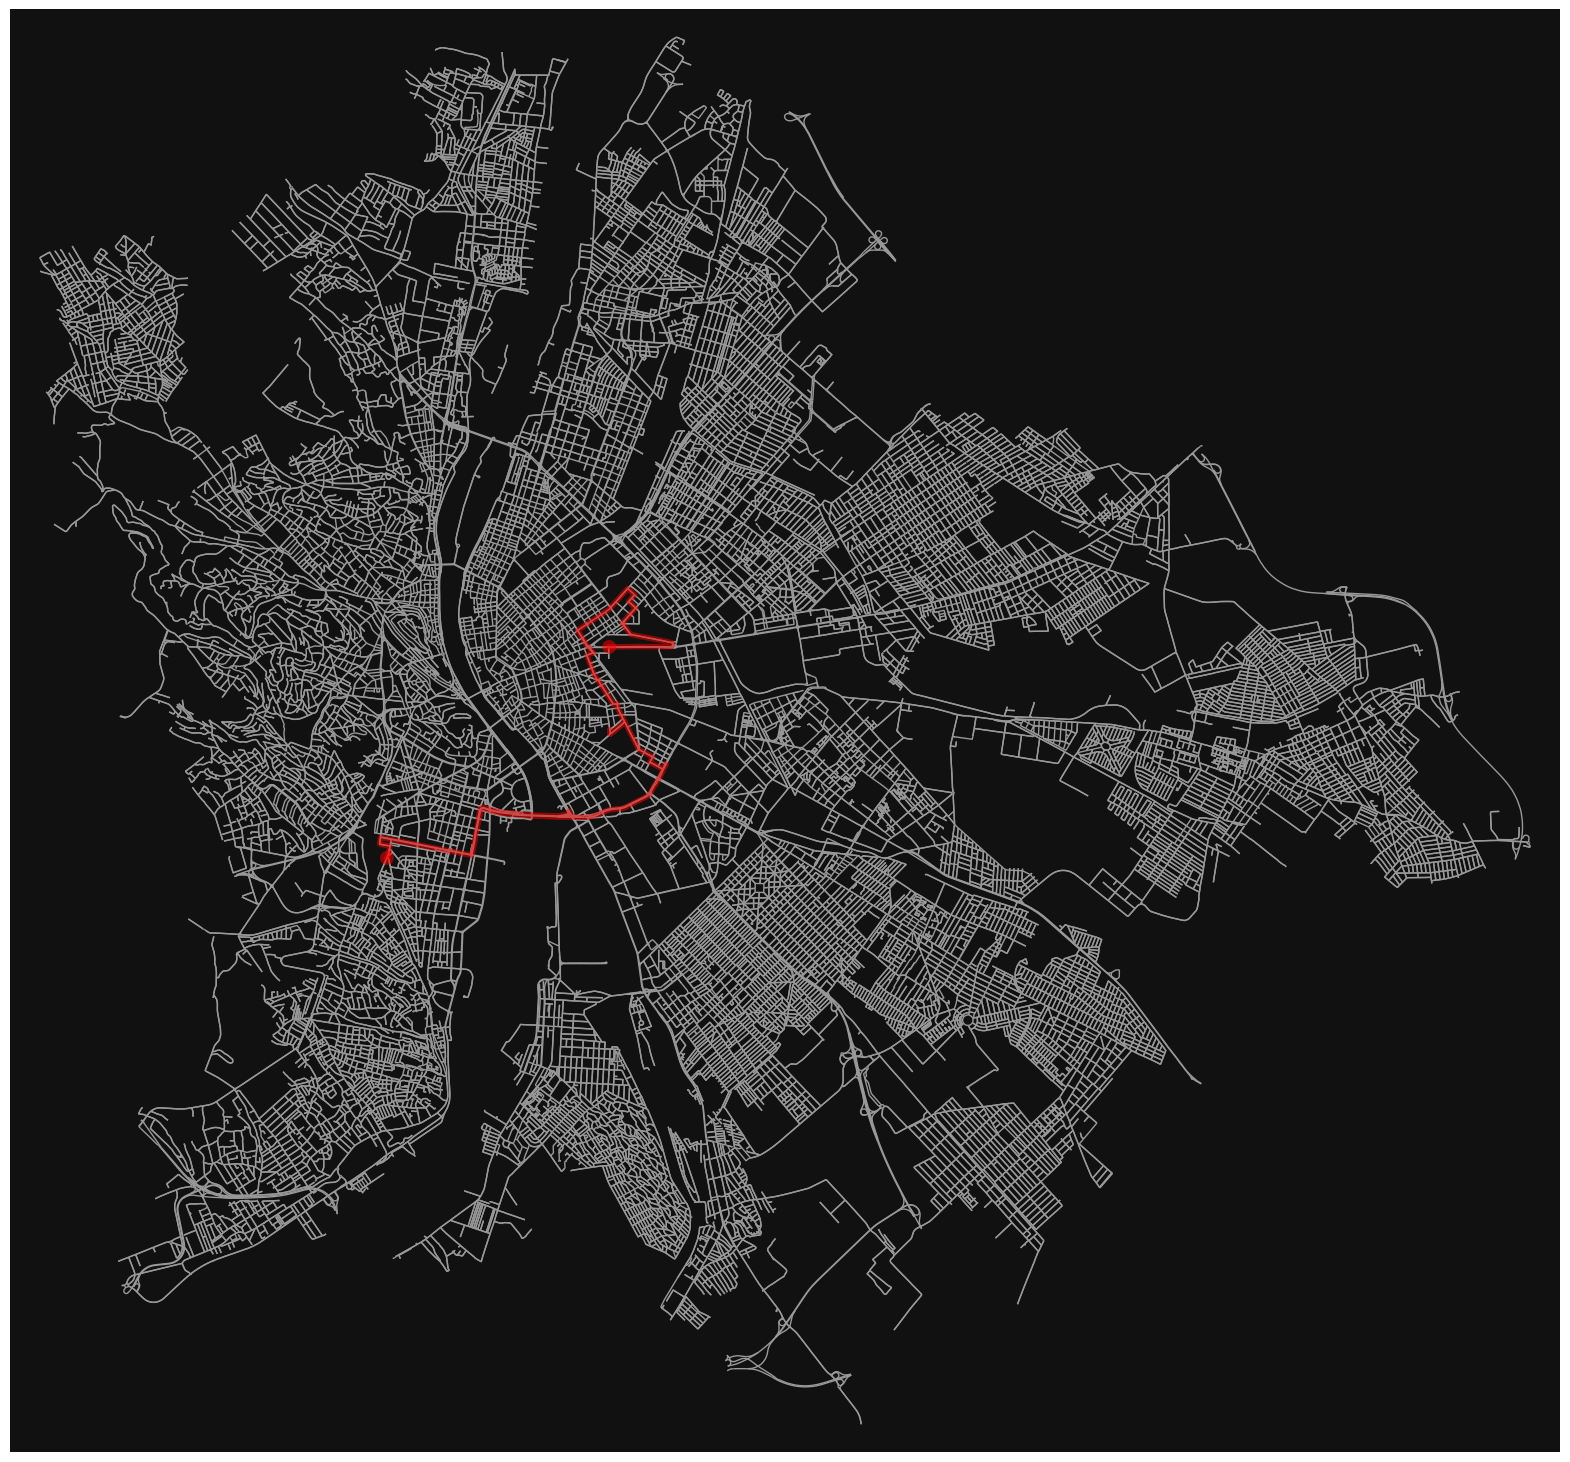

In [9]:
def heur_func(tourism_place, nearest_node, source_node, target_node):
    if tourism_place[1]['tourism'] in ['hotel', 'hostel', 'motel', 'information', 'guest_house', 'apartment']:
        return -1
    try:
        path_length_from_source = nx.shortest_path_length(G, source_node, nearest_node)
        path_length_to_target = nx.shortest_path_length(G, nearest_node, target_node)
        score = 100/(path_length_from_source + path_length_to_target)
        keys = tourism_place[1].keys()
        relevant_tags = {   'name'          : 100,
                            'name:en'       : 20,
                            'url'           : 60,
                            'website'       : 60,
                            'phone'         : 50,
                            'email'         : 50,
                            'facebook'      : 50,
                            'wikipedia'     : 50,
                            'artist_name'   : 10
                         }
        for tag, value in relevant_tags.items():
            if tag in keys and isinstance(tourism_place[1][tag], str):
                score = score + value
        return score
    except Exception as ex:
        print(str(ex) + "\n" + str(tourism_place))
        return -1

def generate_key(tourism_place_details):
    relevant_tags = ['tourism', 'name', 'alt_name']
    keys = tourism_place_details.keys()
    key_dict = []
    for tag in relevant_tags:
        if tag in keys and isinstance(tourism_place_details[tag], str):
            key_dict.append((tag, tourism_place_details[tag]))
    return str(key_dict)

def get_tourism_route(source, target, max_dist=1000, max_tourism_places=5):
    source_node = ox.nearest_nodes(G, source[0], source[1])
    target_node = ox.nearest_nodes(G, target[0], target[1])
    route = nx.shortest_path(G, source_node, target_node)
    heuristic_values = {}

    evaluated_tourism_places = set()
    # collect near tourist places
    index = 0
    for node in route:
        tourism_places = ox.geometries.geometries_from_point((G.nodes[node]['y'], G.nodes[node]['x']), tags={'tourism': True}, dist=max_dist)
        for tourism_place in tourism_places.iterrows():
            key = generate_key(tourism_place[1])
            if key not in evaluated_tourism_places:
                evaluated_tourism_places.add(key)
                geometry = tourism_place[1].geometry
                x = geometry.centroid.x
                y = geometry.centroid.y
                nearest_node = ox.nearest_nodes(G, x, y)
                score = heur_func(tourism_place, nearest_node, source_node, target_node)
                if score > 0:
                    heuristic_values[key] = (score, index, nearest_node, tourism_place[1])
                    index = index + 1
    
    places_sorted_by_scores = {k: v for k, v in sorted(heuristic_values.items(), key=lambda item: item[1][0], reverse=True)}
    places_sorted_by_scores = list(places_sorted_by_scores.items())
    shortlisted_places = {}
    for i in range(min(max_tourism_places, len(places_sorted_by_scores))):
        shortlisted_places[places_sorted_by_scores[i][0]] = places_sorted_by_scores[i][1]
    places_in_visiting_order = {k: v for k, v in sorted(shortlisted_places.items(), key=lambda item: item[1][1], reverse=False)}

    route = []
    # TODO: visit tourist places in their original order
    for key, value in places_in_visiting_order.items():
        tourism_target_node = value[2]
        shortest_path = nx.shortest_path(G, source_node, tourism_target_node)[:-1]
        print(key)
        # ox.plot_graph_route(G, shortest_path, node_size=0, figsize=(10,10))
        route += shortest_path
        source_node = tourism_target_node
    
    route += nx.shortest_path(G, source_node, target_node)
    ox.plot_graph_route(G, route, node_size=0, figsize=(20,20))
    return route

route = get_tourism_route(source, target, max_dist=1000, max_tourism_places=5)

In [10]:
route

[3097782728,
 59768162,
 1811906090,
 1811906093,
 268732979,
 1308092210,
 1308092206,
 59768240,
 2052921652,
 263258025,
 59768247,
 223746850,
 435189038,
 59768256,
 152550350,
 256537955,
 256537844,
 41468928,
 154476503,
 268883048,
 154476505,
 154422835,
 268745520,
 3308156710,
 60760380,
 702000920,
 1654525673,
 1654525674,
 1654525677,
 215418507,
 280286566,
 280286547,
 41468870,
 59770457,
 685050576,
 6253622407,
 3307985635,
 154422835,
 268745520,
 3308156710,
 60760380,
 84696038,
 305190128,
 1408226495,
 305187095,
 60760387,
 280336692,
 60760389,
 694096833,
 652910955,
 130591284,
 151015385,
 1418729903,
 1418729907,
 151015316,
 280186447,
 280186446,
 280186486,
 280186487,
 280186485,
 280186470,
 280186461,
 293930456,
 293930495,
 280186438,
 280186436,
 4274491164,
 268245564,
 268246340,
 268245564,
 4274491164,
 494297207,
 494296683,
 259710781,
 259710782,
 101497075,
 494295594,
 258338755,
 1104328498,
 1104328968,
 280178487,
 280178486,
 2801785